In [10]:
from gevent import monkey
monkey.patch_all()
import datetime
import os.path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [11]:
def plot_metric(axsis,data,metric_name,treatment):
    data["t"] = data["timestamp"] - data["timestamp"].min()
    t0 = data[data[treatment] == treatment]["t"].min()
    t1 = data[data[treatment] == treatment]["t"].max()


    sns.lineplot(data=data,y=metric_name,x="t",ax=axsis)
    axsis.axvline(x=t0, linestyle='--', color='gray', label='t0')
    axsis.axvline(x=t1, linestyle='--', color='gray', label='t1')

    custom_xticks = [data["t"].min(), data["t"].max()] + [t0, t1]

    custom_tick_labels = ["",""]+ ["t0", "t1"]
    axsis.set_xticks(custom_xticks)
    axsis.set_xticklabels(custom_tick_labels,rotation=45)

    axsis.set_xlabel("")
    axsis.set_ylabel("")
    axsis.set_title(metric_name)

    xlim = axsis.get_xlim()
    xlim=(round(xlim[0]*0.1),round(xlim[1]*0.8))
    axsis.set_xlim(xlim)

def plot_traces(axsis,data,treatment):
    t0 = data[data[treatment] == treatment]["start_time"].min()
    t1 = data[data[treatment] == treatment]["start_time"].max()


    # sns.scatterplot(data=data,y="dur",x="t",ax=axsis)


    sns.scatterplot(data=data, x="start_time", y="duration", color="b",ax=axsis)
    axsis.axvline(x=t0, linestyle='--', color='gray', label='t0')
    axsis.axvline(x=t1, linestyle='--', color='gray', label='t1')

    custom_xticks = [data["start_time"].min(), data["start_time"].max()] + [t0, t1]

    custom_tick_labels = ["",""]+ ["t0", "t1"]
    axsis.set_xticks(custom_xticks)
    axsis.set_xticklabels(custom_tick_labels,rotation=45)
    axsis.set_xlabel("")
    axsis.set_ylabel("")
    axsis.set_title("Trace Duration")


In [12]:
from evaluation import Report
report = Report.from_file("loss50_test.yaml")
for run in report.runs:
    basekey = f"experiments/recommendation_loss50.yml/{run.id}"
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 2])


    X = pd.read_hdf('store.h5',key=f"{basekey}/system_CPU")
    plot_metric(fig.add_subplot(gs[0, 0]),X,"system_CPU","packet_loss_treatment")

    X = pd.read_hdf('store.h5',key=f"{basekey}/frontend_traces")
    plot_traces(fig.add_subplot(gs[0, 1]),X,"packet_loss_treatment")

    X = pd.read_hdf('store.h5',key=f"{basekey}/recommendations_total")
    plot_metric(fig.add_subplot(gs[0, 2]),X,"recommendations_total","packet_loss_treatment")

    plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: 'loss50_test.yaml'

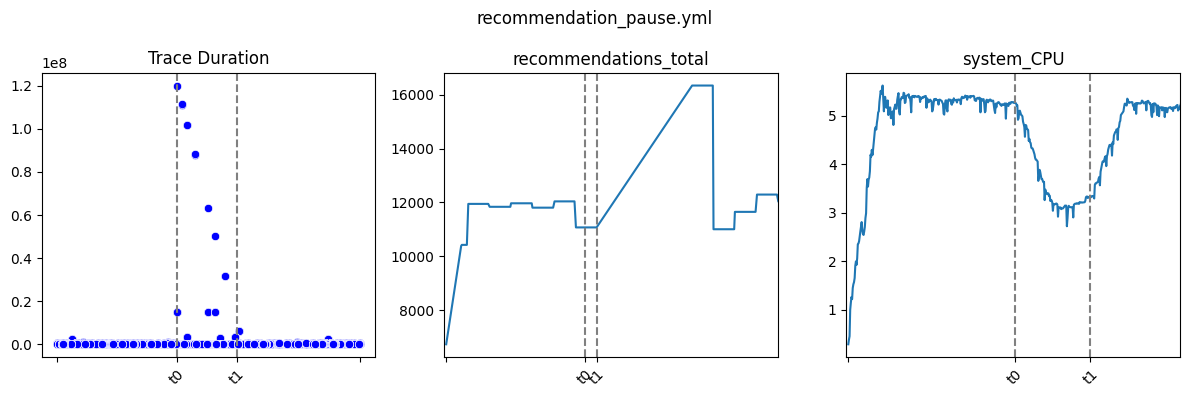

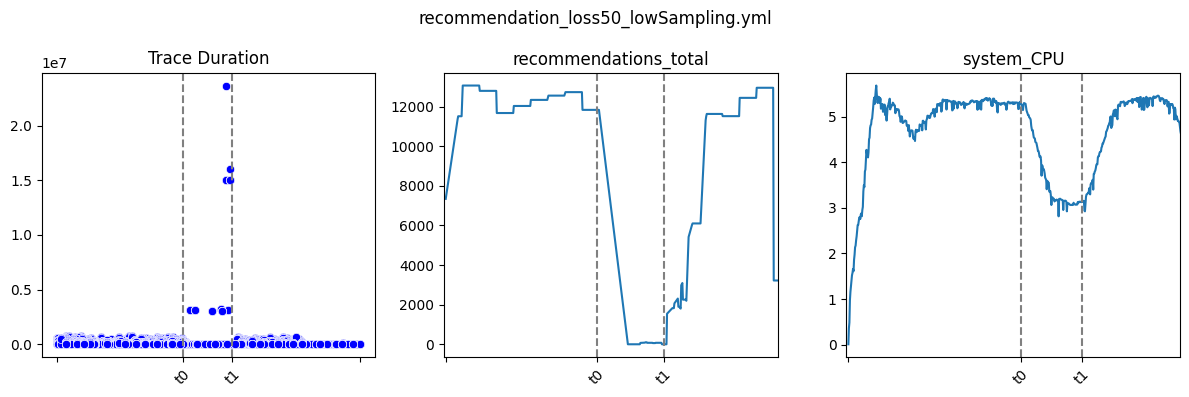

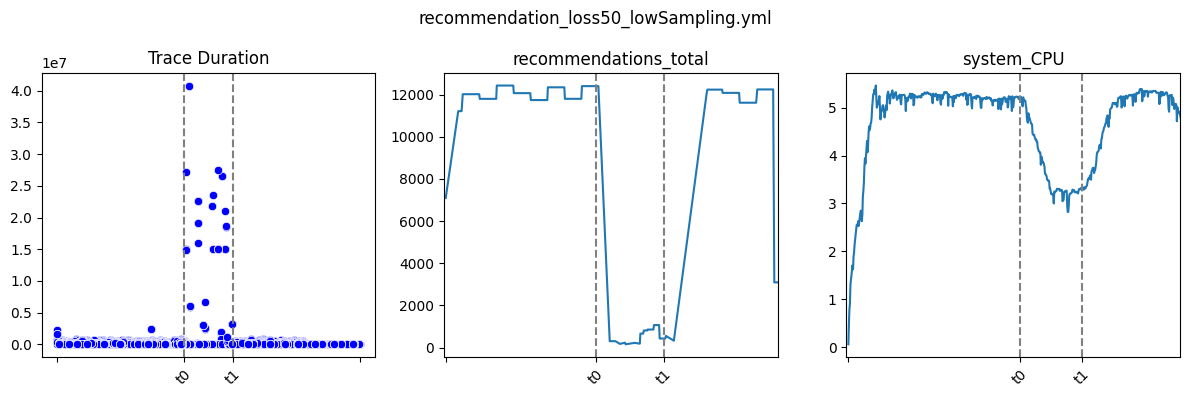

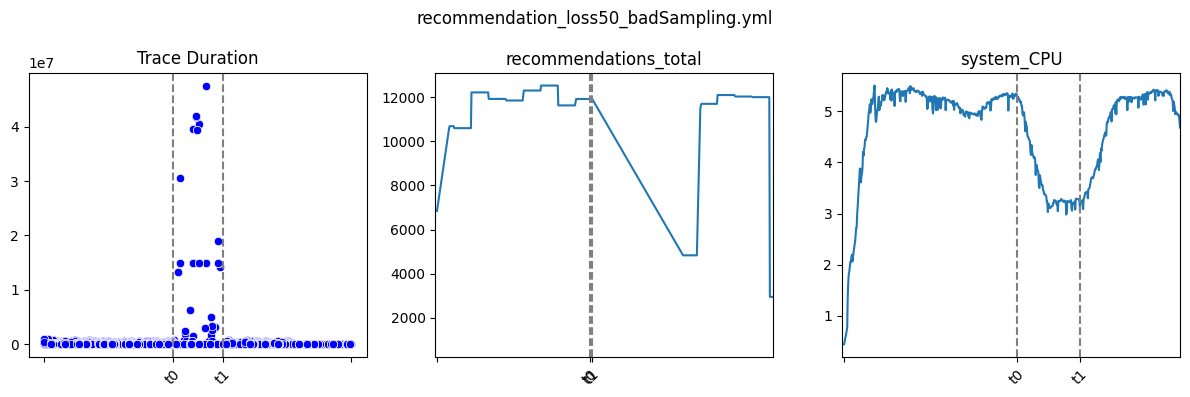

In [13]:
experiments = {}
with pd.HDFStore("store.h5","r") as store:
    keys = store.keys()
    for k in keys:
        
        experiment = k[:k.rindex("/")]
        if not experiment in experiments:
            experiments[experiment] = []
        experiments[experiment].append(k)

for name,keys in experiments.items():
    

    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, len(keys))


    for i,experiment in enumerate(keys):    
        X = pd.read_hdf('store.h5',key=experiment)
        ax = fig.add_subplot(gs[0, i])
        if "traces" in experiment:
            plot_traces(ax,X,"packet_loss_treatment")
        else:
            plot_metric(ax,X,experiment[experiment.rindex("/")+1:],"packet_loss_treatment")
    plt.suptitle(name.split("/")[2])
    plt.tight_layout()

In [60]:
# start with an existing report
from gevent import monkey
monkey.patch_all()
from evaluation import Report
report = Report.from_file("test_report.yml")

In [66]:
# list all interactions
interactions = report.interactions
interactions

[Interaction(treatment=NetworkDelayTreatment, response=TraceResponseVariable),
 Interaction(treatment=MetricsExportIntervalTreatment, response=TraceResponseVariable),
 Interaction(treatment=NetworkDelayTreatment, response=MetricResponseVariable),
 Interaction(treatment=MetricsExportIntervalTreatment, response=MetricResponseVariable),
 Interaction(treatment=NetworkDelayTreatment, response=TraceResponseVariable),
 Interaction(treatment=MetricsExportIntervalTreatment, response=TraceResponseVariable),
 Interaction(treatment=NetworkDelayTreatment, response=MetricResponseVariable),
 Interaction(treatment=MetricsExportIntervalTreatment, response=MetricResponseVariable),
 Interaction(treatment=NetworkDelayTreatment, response=TraceResponseVariable),
 Interaction(treatment=MetricsExportIntervalTreatment, response=TraceResponseVariable),
 Interaction(treatment=NetworkDelayTreatment, response=MetricResponseVariable),
 Interaction(treatment=MetricsExportIntervalTreatment, response=MetricResponseVar

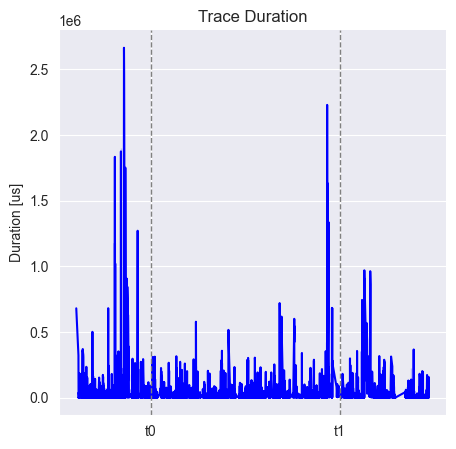

In [67]:
# plot the first interaction
first_interaction = interactions[0]
first_interaction.plot_interaction()

In [76]:
# set a classifier and build a model to compute scores
# use logistic regression for this example
classifier = "LR"
# the default scoring method is f1
model = first_interaction.get_model()
# train the model with default parameters
model.build_lr()

In [77]:
# return the visibility score for a specific interaction model
model.visibility_score()

0.5549932523616734

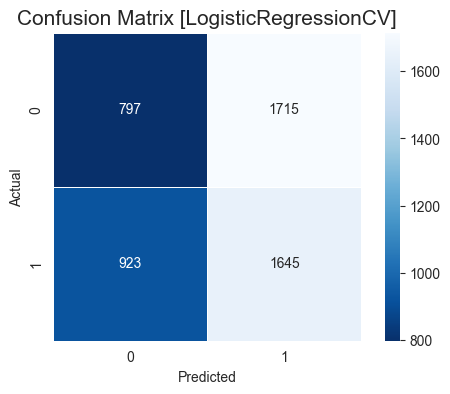

In [79]:
# look at some diagnostic plots for the model
model.plot_confusion_matrix()

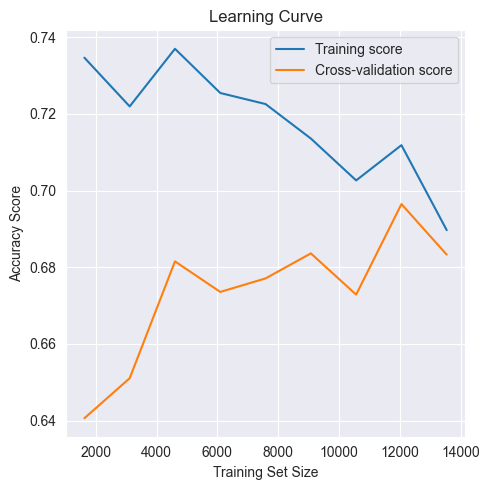

In [80]:
model.plot_lr_learning_curve()

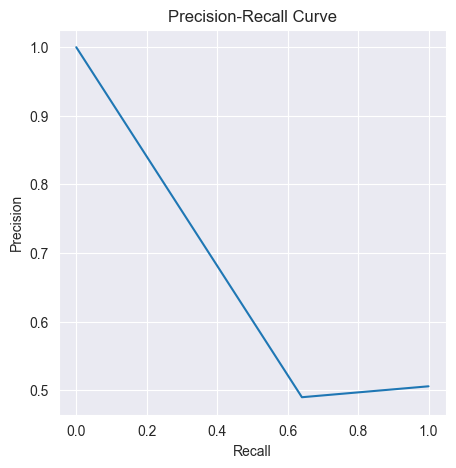

In [81]:
model.plot_precision_recall_curve()

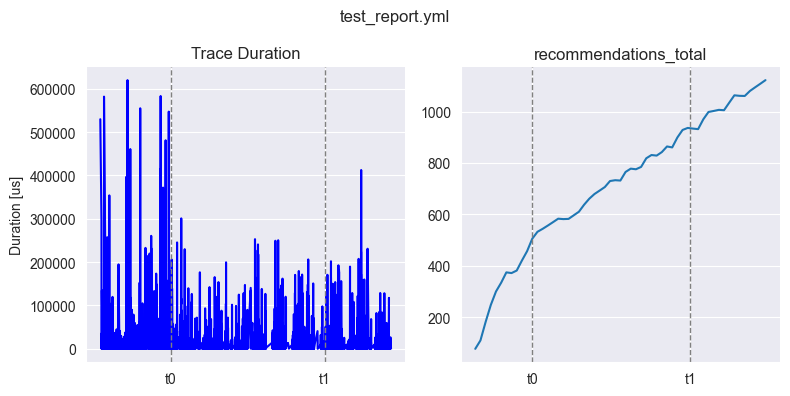

In [47]:
# display multiple interactions in a grid
report.plot_interaction_grid(interactions=[0, 2], rows=1, cols=2)

In [71]:
# return visibility scores for all interactions as a dataframe
visibility = report.get_visibility_df(use_traces=True, folds=2)
visibility

,report,treatment_name,treatment_type,response_name,response_type,classifier,visibility[f1]
0,test_report.yml,short_delay_treatment,NetworkDelayTreatment,frontend_traces.duration,TraceResponseVariable,LR,0.649746
1,test_report.yml,sampling,MetricsExportIntervalTreatment,frontend_traces.duration,TraceResponseVariable,LR,0.182306
2,test_report.yml,short_delay_treatment,NetworkDelayTreatment,recommendations_total,MetricResponseVariable,LR,0.676136
3,test_report.yml,sampling,MetricsExportIntervalTreatment,recommendations_total,MetricResponseVariable,LR,0.958949
4,test_report.yml,short_delay_treatment,NetworkDelayTreatment,frontend_traces.duration,TraceResponseVariable,LR,0.590909
5,test_report.yml,sampling,MetricsExportIntervalTreatment,frontend_traces.duration,TraceResponseVariable,LR,0.659389
6,test_report.yml,short_delay_treatment,NetworkDelayTreatment,recommendations_total,MetricResponseVariable,LR,0.683333
7,test_report.yml,sampling,MetricsExportIntervalTreatment,recommendations_total,MetricResponseVariable,LR,0.960000
8,test_report.yml,short_delay_treatment,NetworkDelayTreatment,frontend_traces.duration,TraceResponseVariable,LR,0.281437
9,test_report.yml,sampling,MetricsExportIntervalTreatment,frontend_traces.duration,TraceResponseVariable,LR,0.291339
